## Homework

The goal of this homework is to familiarize users with monitoring for ML batch services, using PostgreSQL database to store metrics and Grafana to visualize them.

## Q1. Prepare the dataset

Start with `baseline_model_nyc_taxi_data.ipynb`. Download the March 2024 Green Taxi data. We will use this data to simulate a production usage of a taxi trip duration prediction service.

What is the shape of the downloaded data? How many rows are there?

* 72044
* 78537 
* 57457
* 54396


In [34]:
import requests
import datetime
import pandas as pd

#Evidently
from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric, ColumnQuantileMetric, ColumnCorrelationsMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [3]:
files = [('green_tripdata_2024-03.parquet', './taxi_monitoring/data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2024-03.parquet: 100%|██████████| 1372372/1372372 [00:10<00:00, 129747.54it/s, save to ./taxi_monitoring/data/green_tripdata_2024-03.parquet]


In [90]:
march_data = pd.read_parquet('./taxi_monitoring/data/green_tripdata_2024-03.parquet')

In [91]:
march_data.shape

(57457, 20)

R= **57457**

## Q2. Metric

Let's expand the number of data quality metrics we’d like to monitor! Please add one metric of your choice and a quantile value for the `"fare_amount"` column (`quantile=0.5`).

Hint: explore evidently metric `ColumnQuantileMetric` (from `evidently.metrics import ColumnQuantileMetric`) 

What metric did you choose?


-> **ColumnCorrelationsMetric**

## Q3. Monitoring

Let’s start monitoring. Run expanded monitoring for a new batch of data (March 2024). 

What is the maximum value of metric `quantile = 0.5` on the `"fare_amount"` column during March 2024 (calculated daily)?

* 10
* 12.5
* 14.2
* 14.8


In [92]:
# create target
march_data["duration_min"] = march_data.lpep_dropoff_datetime - march_data.lpep_pickup_datetime
march_data.duration_min = march_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [93]:
# filter out outliers
march_data = march_data[(march_data.duration_min >= 0) & (march_data.duration_min <= 60)]
march_data = march_data[(march_data.passenger_count > 0) & (march_data.passenger_count <= 8)]

<Axes: >

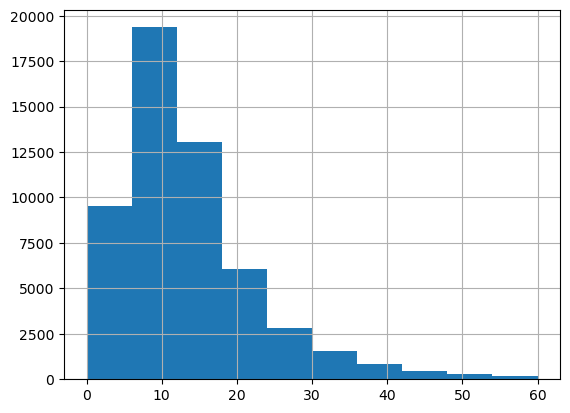

In [94]:
march_data.duration_min.hist()

In [95]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [96]:
with open('./taxi_monitoring/models/lin_reg.bin', 'rb') as f_in:
    model = load(f_in)

In [97]:
column_mapping = ColumnMapping(
    target=None,
    prediction=None,
    numerical_features=num_features,
    categorical_features=cat_features
)

In [100]:
regular_report = Report(metrics=[
    ColumnQuantileMetric(column_name="fare_amount", quantile=0.5)
])

In [105]:
from evidently.metric_preset import DataDriftPreset, DataQualityPreset

from evidently.ui.workspace import Workspace
from evidently.ui.dashboards import DashboardPanelCounter, DashboardPanelPlot, CounterAgg, PanelValue, PlotType, ReportFilter
from evidently.renderers.html_widgets import WidgetSize

In [106]:
# create a workspace
ws = Workspace("workspace")

In [107]:
# Create a project
project = ws.create_project("NYC Taxi Data Quality Project")
project.description = "My project description"
project.save()

Project(id=UUID('fa689af0-a71d-43cc-ac7a-9c9cf92a9972'), name='NYC Taxi Data Quality Project', description='My project description', dashboard=DashboardConfig(name='NYC Taxi Data Quality Project', panels=[], tabs=[], tab_id_to_panel_ids={}), team_id=None, date_from=None, date_to=None, created_at=datetime.datetime(2024, 6, 23, 19, 30, 29, 488908))

In [108]:
daily_quantiles = []

for i in range (1, 31):
    regular_report.run(reference_data=None,
                current_data=march_data.loc[march_data.lpep_pickup_datetime.between(f'2024-03-{i:02}', f'2024-03-{i+1:02}', inclusive="left")],
                column_mapping=column_mapping)

    result = regular_report.as_dict()

    ws.add_report(project.id, regular_report)
    quantile = result['metrics'][0]['result']['current']['value']
    daily_quantiles.append(quantile)


In [110]:
#configure the dashboard
project.dashboard.add_panel(
    DashboardPanelCounter(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        agg=CounterAgg.NONE,
        title="NYC taxi data dashboard"
    )
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Inference Count",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_rows",
                legend="count"
            ),
        ],
        plot_type=PlotType.BAR,
        size=WidgetSize.HALF,
    ),
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Number of Missing Values",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_missing_values",
                legend="count"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.save()

Project(id=UUID('fa689af0-a71d-43cc-ac7a-9c9cf92a9972'), name='NYC Taxi Data Quality Project', description='My project description', dashboard=DashboardConfig(name='NYC Taxi Data Quality Project', panels=[DashboardPanelCounter(type='evidently.ui.dashboards.reports.DashboardPanelCounter', id=UUID('0809f49d-39fb-4011-989d-5913ee155f19'), title='NYC taxi data dashboard', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.FULL: 2>, agg=<CounterAgg.NONE: 'none'>, value=None, text=None), DashboardPanelPlot(type='evidently.ui.dashboards.reports.DashboardPanelPlot', id=UUID('57d0ae5a-2131-48e9-852e-cea9b632c834'), title='Inference Count', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.HALF: 1>, values=[PanelValue(field_path='current.number_of_rows', metric_id='DatasetSummaryMetric', metric_fingerprint=None, metric_args={}, legend='count')], plot_type=<PlotType.BAR: 'bar'>), DashboardPanelPlot(

In [109]:
max(daily_quantiles)

14.2

## Q4. Dashboard


Finally, let’s add panels with new added metrics to the dashboard. After we customize the  dashboard let's save a dashboard config, so that we can access it later. Hint: click on “Save dashboard” to access JSON configuration of the dashboard. This configuration should be saved locally.

Where to place a dashboard config file?

* `project_folder` (05-monitoring)
* `project_folder/config`  (05-monitoring/config)
* `project_folder/dashboards`  (05-monitoring/dashboards)
* `project_folder/data`  (05-monitoring/data)

-> project_folder/dashboards